In [1]:
import h5py
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.signal
import json

In [2]:
path_to_data = 'LOSC_Event_tutorial/'

In [3]:
import simple_read_ligo as read
f = open(path_to_data+ 'BBH_events_v3.json')
events = json.load(f)

All steps are written within the class and are called sequencially.

In [74]:
class mf(object):
    def __init__(self,event):
        
        '''load the templates and data for each detector for given event and read out data'''
        L_path =  path_to_data +  events[event]['fn_L1']
        H_path =  path_to_data + events[event]['fn_H1']
        template_path = path_to_data + events[event]['fn_template']
        
        self.strain_L,self.dt_L,self.utc_L=read.read_file(L_path)
        self.strain_H,self.dt_H,self.utc_H=read.read_file(H_path)
        self.TH,self.TL=read.read_template(template_path)
        
        self.fft_strain_L = np.fft.rfft(self.strain_L)
        self.fft_strain_H = np.fft.rfft(self.strain_H)
        
        self.fft_TH = np.fft.rfft(self.TH)
        self.fft_TL = np.fft.rfft(self.TL)
        
        
    def window(self, data, alpha=0.5):
        '''window any given strain or template using Tukey window (cosine with flat top)'''
        
        n=len(data)
        win = scipy.signal.windows.tukey(n,alpha)
        
        self.data_win = data*win 
        self.fft_data_win = np.fft.rfft(data*win)
        
        return self.fft_data_win
        
        
    def whiten_smooth(self,data,strain):
        '''Given data should go through window function'''
        
        self.NM = np.abs(strain)**2
        self.N_smooth = np.convolve(self.NM,np.ones(100)/100,mode='same')
        
        white_fft=data/np.sqrt(self.N_smooth)
        white =np.fft.irfft(white_fft)
        
        return white, white_fft, self.N_smooth
    
    
    def matched_filter(self,strain,template):
        '''Strain and template are both windowed, smoothed and whitened'''
        
        xcorr = np.fft.irfft((strain)*np.conj(template))
        xcorr_fft = strain*np.conj(template)
        

        return xcorr,xcorr_fft
    
    
    def find_weight(self,mf_fft):
        '''Matched filter is in fft space'''
        
        #find the time span for time in spatial space 
        t = np.linspace(0,32,len(mf_fft)*2)
        

        #convert to fourier space to get frequencies 
        freq = np.fft.rfftfreq(len(t),1/4096)

        
        #plt.plot(freq[1:], mf_fft )

        #find the half of the total area
        area = np.sum(np.abs(mf_fft)*(freq[1]-freq[0]))
        target = area/2

        #loop to find frequency
        for i in range(len(freq)): 
            area = np.sum(np.abs(mf_fft[:i])*(freq[1]-freq[0]))
            #print(area)
            if np.abs(area - target ) < 5: 
                half_freq = freq[i]
                #print('Found the frequency')
                break
        return half_freq
        
        
        

Below is the noise templates for each event and location. These are all windowed with a Tukey window and smoothed using a convolution. The noise model is then used to whiten the strain and the template.

## Noise Models - Livingstong

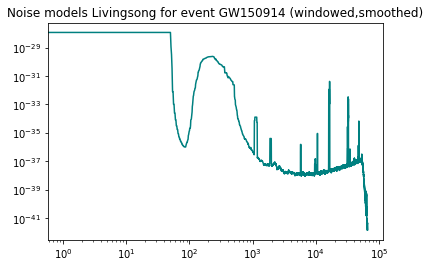

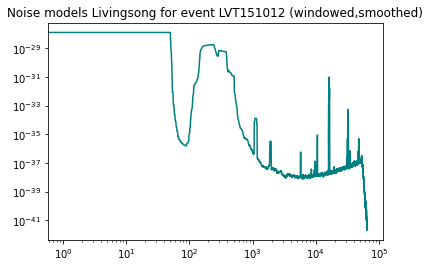

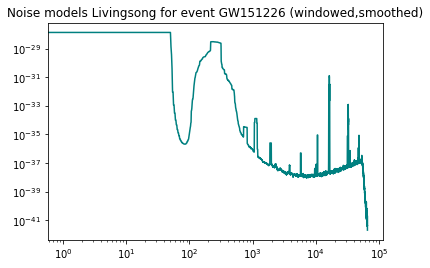

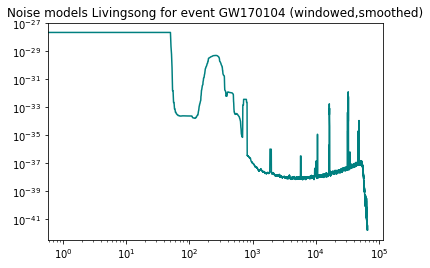

In [78]:
all_e = ['GW150914','LVT151012','GW151226','GW170104']

for i in all_e: 
    get_mf = mf(i)
    
    ps = get_mf.whiten_smooth(get_mf.window(get_mf.TL),get_mf.window(get_mf.strain_L))[2]
    
    plt.title('Noise models Livingsong for event {} (windowed,smoothed)'.format(i))
    plt.loglog(ps,color= 'teal' )
    plt.show()


## Noise Models - Hanford

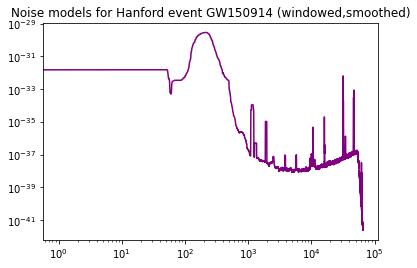

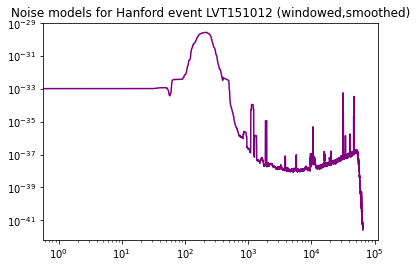

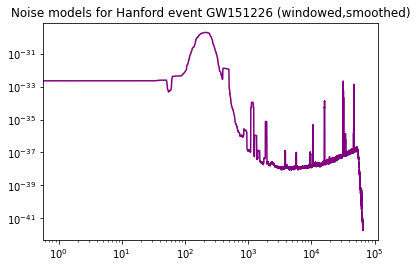

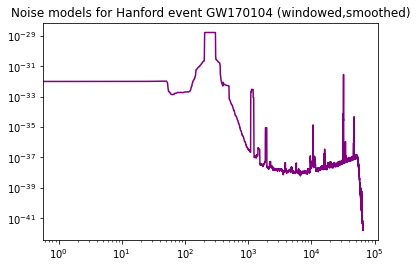

In [80]:
all_e = ['GW150914','LVT151012','GW151226','GW170104']

for i in all_e: 
    get_mf = mf(i)
    
    ps = get_mf.whiten_smooth(get_mf.window(get_mf.TH),get_mf.window(get_mf.strain_H))[2]
    
    plt.title('Noise models for Hanford event {} (windowed,smoothed)'.format(i))
    plt.loglog(ps,color= 'purple' )
    plt.show()

Next is the matched filters which are the correlation between the windowed, smoothed, and whitened strains and templates, they show the peak of the least squares fit between the strain and the template as one is moved across the other. This is the location of the gravitational wave above the noise.

## Matched filters Livingston

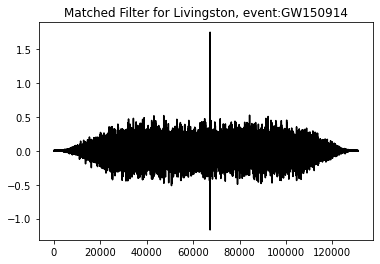

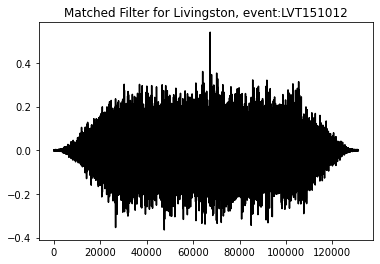

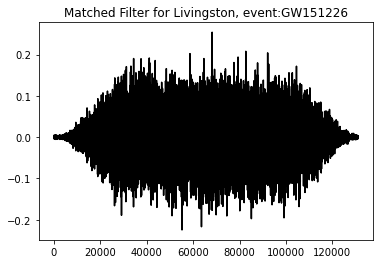

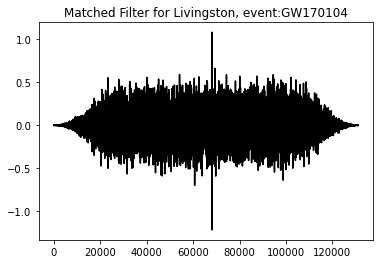

In [26]:
all_e = ['GW150914','LVT151012','GW151226','GW170104']

for i in all_e: 
    get_mf = mf(i)
    
    white_T = get_mf.whiten_smooth(get_mf.window(get_mf.TL),get_mf.window(get_mf.strain_L))[1]
    white_s = get_mf.whiten_smooth(get_mf.window(get_mf.strain_L),get_mf.window(get_mf.strain_L))[1]
    
    xcorr = get_mf.matched_filter(white_s, white_T)[0]
    
    plt.plot(np.fft.fftshift(xcorr),'k')
    plt.title('Matched Filter for Livingston, event:{}'.format(i))
    plt.show()
    
    

## Matched filters Hanford

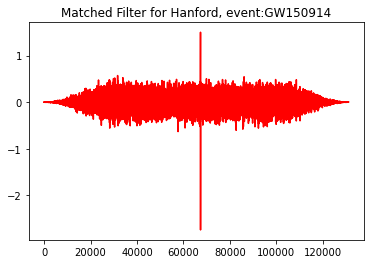

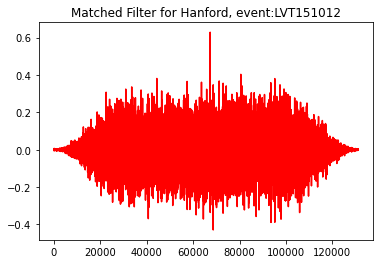

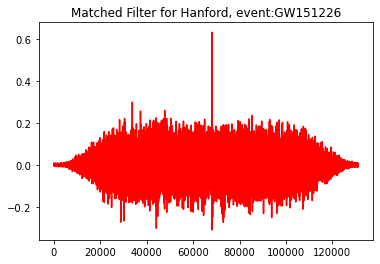

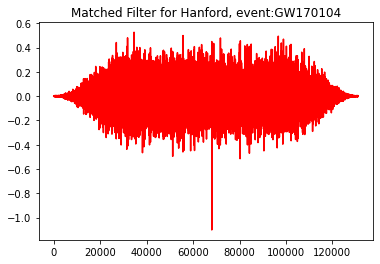

In [27]:
all_e = ['GW150914','LVT151012','GW151226','GW170104']

for i in all_e: 
    get_mf = mf(i)
    
    white_T = get_mf.whiten_smooth(get_mf.window(get_mf.TH),get_mf.window(get_mf.strain_H))[1]
    white_s = get_mf.whiten_smooth(get_mf.window(get_mf.strain_H),get_mf.window(get_mf.strain_H))[1]
    
    xcorr = get_mf.matched_filter(white_s, white_T)[0]
    
    plt.plot(np.fft.fftshift(xcorr),'r')
    plt.title('Matched Filter for Hanford, event:{}'.format(i))
    plt.show()
    

The scatter signal to noise is computed by taking the standard deviation of a chunck of the noise in the matched filter where there is no signal and then dividing that from the peak value where the gravitational wave is. The analytical signal to noise is computed by taking the matched filter of the whitened template with itself. This represents what would we expect to get for the signal to noise. As seen below the values are relatively consistent but are not exact. This is because the scatter signal comes from the actual data strain which has a lot more correlated noise and although we attempted to smooth and whiten it, this could be improved upon.

## SNR - Livington

In [64]:
all_e = ['GW150914','LVT151012','GW151226','GW170104']

for i in all_e: 
    
    get_mf = mf(i)
    
    white_T = get_mf.whiten_smooth(get_mf.window(get_mf.TL),get_mf.window(get_mf.strain_L))[1]
    white_s = get_mf.whiten_smooth(get_mf.window(get_mf.strain_L),get_mf.window(get_mf.strain_L))[1]

    
    #get the analytical snr
    L = np.abs(get_mf.matched_filter(white_T, white_T)[0])
    L_snr_an =  np.max(L)/ np.std(L[:2000])


    #get the calculated snr 
    xcorr = np.abs(get_mf.matched_filter(white_s, white_T)[0])
    L_snr = xcorr.max()/ np.std(np.abs(xcorr[10000:30000]))
    
    print('Noise for Livingston event {} is {}'.format(i,np.std(np.abs(xcorr[10000:30000]))))
    print('Sactter SNR for Livingston event {} is {}'.format(i,L_snr))
    print('Analytical SNR for Livingston event {} is {}'.format(i,L_snr_an))
    print('')


Noise for Livingston event GW150914 is 0.08455168658578348
Sactter SNR for Livingston event GW150914 is 20.60770702405295
Analytical SNR for Livingston event GW150914 is 19.60361056945489

Noise for Livingston event LVT151012 is 0.057013629868936405
Sactter SNR for Livingston event LVT151012 is 9.476819393619921
Analytical SNR for Livingston event LVT151012 is 18.1509690289693

Noise for Livingston event GW151226 is 0.031423163762753656
Sactter SNR for Livingston event GW151226 is 8.088917060009534
Analytical SNR for Livingston event GW151226 is 20.108618200970167

Noise for Livingston event GW170104 is 0.09990499107718817
Sactter SNR for Livingston event GW170104 is 12.197620308742685
Analytical SNR for Livingston event GW170104 is 16.4423894196093



## SNR - Hanford

In [67]:
all_e = ['GW150914','LVT151012','GW151226','GW170104']

for i in all_e: 
    
    get_mf = mf(i)
    
    white_T = get_mf.whiten_smooth(get_mf.window(get_mf.TH),get_mf.window(get_mf.strain_H))[1]
    white_s = get_mf.whiten_smooth(get_mf.window(get_mf.strain_H),get_mf.window(get_mf.strain_H))[1]

    
    #get the analytical snr
    H = np.abs(get_mf.matched_filter(white_T, white_T)[0])
    H_snr_an =  np.max(H)/ np.std(H[:2000])


    #get the calculated snr 
    xcorr = np.abs(get_mf.matched_filter(white_s, white_T)[0])
    H_snr = xcorr.max()/ np.std((xcorr[10000:30000]))
    
    print('Noise for Hanford event {} is {}'.format(i,np.std(np.abs(xcorr[10000:30000]))))
    print('Sactter SNR for Hanford event {} is {}'.format(i,H_snr))
    print('Analytical SNR for Hanford event {} is {}'.format(i,H_snr_an))
    print('')

Noise for Hanford event GW150914 is 0.09062996272208283
Sactter SNR for Hanford event GW150914 is 30.28553465493574
Analytical SNR for Hanford event GW150914 is 19.260896409830046

Noise for Hanford event LVT151012 is 0.06108898420639972
Sactter SNR for Hanford event LVT151012 is 10.290939810826725
Analytical SNR for Hanford event LVT151012 is 17.308669306399214

Noise for Hanford event GW151226 is 0.04131976718749168
Sactter SNR for Hanford event GW151226 is 15.331169330459746
Analytical SNR for Hanford event GW151226 is 16.808691185387467

Noise for Hanford event GW170104 is 0.07594240507461898
Sactter SNR for Hanford event GW170104 is 14.507213134789907
Analytical SNR for Hanford event GW170104 is 18.388207104098196



## SNR - Combined

In [70]:
all_e = ['GW150914','LVT151012','GW151226','GW170104']

for i in all_e: 
    
    get_mf = mf(i)
    
    white_TL = get_mf.whiten_smooth(get_mf.window(get_mf.TL),get_mf.window(get_mf.strain_L))[1]
    white_sL = get_mf.whiten_smooth(get_mf.window(get_mf.strain_L),get_mf.window(get_mf.strain_L))[1]
    
    white_TH = get_mf.whiten_smooth(get_mf.window(get_mf.TH),get_mf.window(get_mf.strain_H))[1]
    white_sH = get_mf.whiten_smooth(get_mf.window(get_mf.strain_H),get_mf.window(get_mf.strain_H))[1]
    
    #get the analytical snr
    L = np.abs(get_mf.matched_filter(white_TL, white_TL)[0])
    H = np.abs(get_mf.matched_filter(white_TH, white_TH)[0])
    
    combined_snr_an =  ((np.max(H)+ np.max(L)) *0.5)/ ((np.std(H[:2000]) + np.std(L[:2000]))*0.5) 


    #get the calculated snr 
    xcorr_L = np.abs(get_mf.matched_filter(white_sL, white_TL)[0])
    xcorr_H = np.abs(get_mf.matched_filter(white_sH, white_TH)[0])
                        
    combined_snr = ((xcorr_L.max() + xcorr_H.max())*0.5)/ ((np.std(np.abs(xcorr_L[10000:30000]))+ np.std(np.abs(xcorr_H[10000:30000]))*0.5))
    
    print('Combined scatter SNR for event {} is {}'.format(i,combined_snr))
    print('Combined analytical SNR for event {} is {}'.format(i,combined_snr_an))
    print('')

Combined scatter SNR for event GW150914 is 17.27615458718734
Combined analytical SNR for event GW150914 is 19.410474205362647

Combined scatter SNR for event LVT151012 is 6.6753997600999915
Combined analytical SNR for event LVT151012 is 17.695576456508455

Combined scatter SNR for event GW151226 is 8.521580033621523
Combined analytical SNR for event GW151226 is 17.84483165205017

Combined scatter SNR for event GW170104 is 8.414490361481572
Combined analytical SNR for event GW170104 is 17.11261700541671



In order to find the freqeuncy where hald of the weight is above and below we can set up the following integreal (done in the find_weight method of the class): 

$\int_0^{f_i} \tilde{MF} dt  = \frac{1}{2}\int_0^{f_{max}} \tilde{MF} dt$

Where $\tilde{MF}$ is the fourier transform of the matched filter. We take the fourier transform in order to see it in frequency space. We are looking for the frequency $f_i$ which corresponds with half the total area in fourier space. This also requires calculating the time span of the events and converting them to fourier space as seen in the find_weight method.



## Frequency of even weight - Livingston 

In [58]:
all_e = ['GW150914','LVT151012','GW151226','GW170104']

for i in all_e: 
    
    get_mf = mf(i)
    
    white_T = get_mf.whiten_smooth(get_mf.window(get_mf.TL),get_mf.window(get_mf.strain_L))[1]
    white_s = get_mf.whiten_smooth(get_mf.window(get_mf.strain_L),get_mf.window(get_mf.strain_L))[1]
    
    xcorr_fft = get_mf.matched_filter(white_s, white_T)[1]
    freq = get_mf.find_weight(xcorr_fft)
    
    print('Frequency for half weight for Livingston, event {} is {} Hz'.format(i,freq))

    

Frequency for half weight for Livingston, event GW150914 is 136.43541816073363 Hz
Frequency for half weight for Livingston, event LVT151012 is 131.0292506523033 Hz
Frequency for half weight for Livingston, event GW151226 is 174.6535849977875 Hz
Frequency for half weight for Livingston, event GW170104 is 114.65450051116163 Hz


## Frequency of even weight - Harford

In [59]:
all_e = ['GW150914','LVT151012','GW151226','GW170104']

for i in all_e: 
    
    get_mf = mf(i)
    
    white_T = get_mf.whiten_smooth(get_mf.window(get_mf.TH),get_mf.window(get_mf.strain_H))[1]
    white_s = get_mf.whiten_smooth(get_mf.window(get_mf.strain_H),get_mf.window(get_mf.strain_H))[1]
    
    xcorr_fft = get_mf.matched_filter(white_s, white_T)[1]
    freq = get_mf.find_weight(xcorr_fft)
    
    print('Frequency for half weight for Hanford, event {} is {} Hz'.format(i,freq))

Frequency for half weight for Hanford, event GW150914 is 131.12299922181364 Hz
Frequency for half weight for Hanford, event LVT151012 is 123.8106108000061 Hz
Frequency for half weight for Hanford, event GW151226 is 143.71655705937104 Hz
Frequency for half weight for Hanford, event GW170104 is 131.52924302302517 Hz


Here we set up the time frame over the event to see when the wave occured

## Time of arrival - Livingston 

Occured at [0.43164392] sec for event GW150914


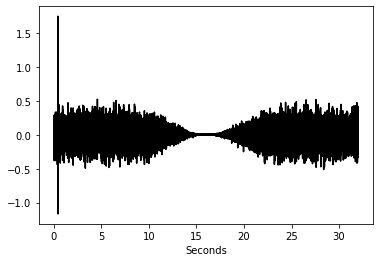

Occured at [0.44336276] sec for event LVT151012


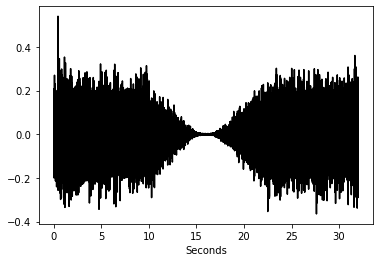

Occured at [0.64795416] sec for event GW151226


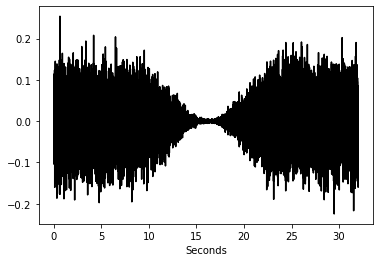

Occured at [0.60937965] sec for event GW170104


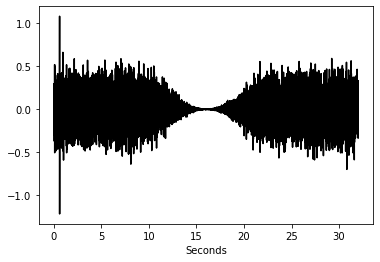

In [93]:
all_e = ['GW150914','LVT151012','GW151226','GW170104']

for i in all_e: 
    get_mf = mf(i)
    
    white_T = get_mf.whiten_smooth(get_mf.window(get_mf.TL),get_mf.window(get_mf.strain_L))[1]
    white_s = get_mf.whiten_smooth(get_mf.window(get_mf.strain_L),get_mf.window(get_mf.strain_L))[1]
    
    xcorr = get_mf.matched_filter(white_s, white_T)[0]
    t = np.linspace(0,32,len(xcorr))
    
    gw = np.where(xcorr == xcorr.max())
    print('Occured at {} sec for event {}'.format(t[gw],i))
    
    plt.plot(t,(xcorr),'k')
    plt.xlabel('Seconds')
    plt.show()

## Time of arrival - Hanford

Occured at [0.43701505] sec for event GW150914


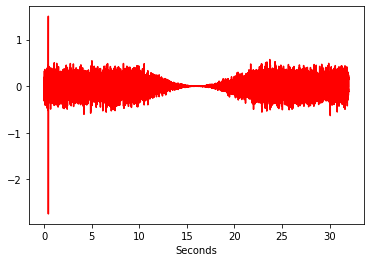

Occured at [0.44140962] sec for event LVT151012


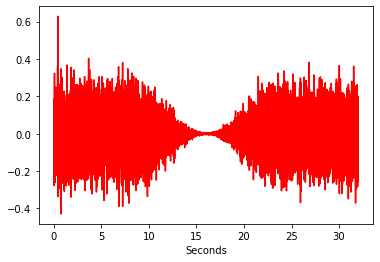

Occured at [0.64771002] sec for event GW151226


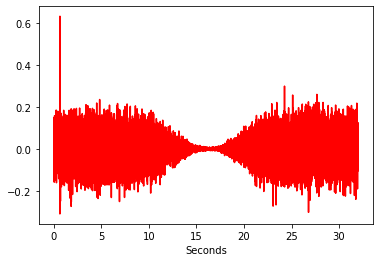

Occured at [24.43817473] sec for event GW170104


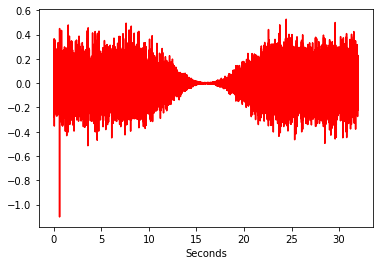

In [94]:
all_e = ['GW150914','LVT151012','GW151226','GW170104']

for i in all_e: 
    get_mf = mf(i)
    
    white_T = get_mf.whiten_smooth(get_mf.window(get_mf.TH),get_mf.window(get_mf.strain_H))[1]
    white_s = get_mf.whiten_smooth(get_mf.window(get_mf.strain_H),get_mf.window(get_mf.strain_H))[1]
    
    xcorr = get_mf.matched_filter(white_s, white_T)[0]
    t = np.linspace(0,32,len(xcorr))
    
    gw = np.where(xcorr == xcorr.max())
    print('Occured at {} sec for event {}'.format(t[gw],i))
    
    plt.plot(t,(xcorr),'r')
    plt.xlabel('Seconds')
    plt.show()